In [1]:
import pandas as pd
import numpy as np
import warnings
import utils
import matplotlib.pyplot as plt
import seaborn as sns

OAK = 'FOAK'
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Import ANR-H2 input parameters

In [2]:
h2_techs = pd.read_excel('./h2_tech.xlsx', sheet_name = 'Summary')
h2_techs.rename(columns={'CAPEX ($/MWe)':'H2 CAPEX ($/MWe)',
                 'FOM ($/MWe-year)':'H2 FOM ($/MWe-year)',
                 'VOM ($/MWhe)':'H2 VOM ($/MWhe)'}, inplace=True)
anrs = pd.read_excel('./ANRs.xlsx', sheet_name=OAK)
anrs.rename(columns={'CAPEX $/MWe':'ANR CAPEX ($/MWe)',
                 'FOPEX $/MWe-y':'ANR FOM ($/MWe-year)',
                 'VOM in $/MWh-e':'ANR VOM ($/MWhe)', 
                 'Startupfixedcost in $':'Start Cost ($)'}, inplace=True)
techs = pd.merge(h2_techs, anrs, left_on='ANR', right_on='Reactor')

# Natural Gas

In [3]:
# Avoided NG costs
def compute_ng_multiplier(temp, AHF_coeffs=[0, -.00038, 0.90556]):
  # Available Heat Fraction
  AHF = AHF_coeffs[0]*(int(temp)**2)+ AHF_coeffs[1]*int(temp) + AHF_coeffs[2]
  multiplier = AHF/utils.mmbtu_to_mj # Unit: MmBtu/MJ
  return multiplier

# Merge state-level prices
ng_prices = pd.read_excel('./input_data/eia_aeo_industrial_sector_ng_prices.xlsx', sheet_name='state_prices')
# 2024 prices
ng_prices = ng_prices[ng_prices.year == 2024]
ng_prices.rename(columns={'price 2020USD/MMBtu':'NG price ($/MMBtu)'}, inplace=True)

# ANR +  ANR-H2 Analysis

## Load batched NREL data from MAX

In [4]:
nrel_data = pd.read_excel('./input_data/direct_heat_maxv/facs_batched.xlsx')
nrel_data.drop(columns=['Unnamed: 0'], inplace=True)
# Convert total from TJ to MJ 

nrel_data.drop(columns=['Total'], inplace=True)
nrel_data.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper'],
      dtype='object')

In [5]:
len(nrel_data)

1764

In [6]:
# Load results from MAX
max_results = pd.read_csv('./input_data/direct_heat_maxv/Full_Spread_SMRs.csv')
max_results.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
max_results.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'Total', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper', 'Reactor', 'Power in MWt', 'Thermal Efficiency',
       'Outlet Temp (C)', 'CAPEX $/MWe_foak', 'FOPEX $/MWe-y_foak',
       'VOM in $/MWh-e_foak', 'CAPEX $/MWe', 'FOPEX $/MWe-y', 'VOM in $/MWh-e',
       'Life (y)', 'Modules', 'SMR_Capacity', 'SMR_Capacity_e',
       'Surplus_Capacity', 'Surplus_Capacity_e', 'CRF', 'Total_CAPEX_FOAK',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 

In [7]:
len(max_results)

7834

## Compute H2 demand for unserved demand

In [8]:
def compute_h2_demand(heat, temp, AHF_coeffs = [0, -0.00038, .90556]):
  """Computes the equivalent hydrogen demand to produce heat 
  Args:
    - heat (float): heat demand in MW
    - temp (float): temperature in degree Celsius
    - AHF_coeffs (list(float)): coefficients for Available Heat Fraction calculation
  Returns:
    - h2_demand (float): hydrogen demand in kg/h
  """
  AHF = AHF_coeffs[0]*(int(temp)^2) + AHF_coeffs[1]*int(temp) + AHF_coeffs[2]
  h2_demand = heat*utils.mwh_to_mj/(utils.h2_hhv*AHF)
  return h2_demand
max_results['Remaining H2 Dem. (kg/h)'] = max_results.apply(lambda x:compute_h2_demand(x['Remaining_Heat_MW'], x['Remaining_temp_degC']), axis=1)

In [9]:
ng_df = max_results[['FACILITY_ID','STATE','Batch_Temp_degC', 'Highest_Temp_served_degC', 'Emissions_mmtco2/y',\
                    'Heat_demand_MWh/hr', 'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod', 'Reactor',\
                    'Modules', 'SMR_Capacity', 'SMR_Capacity_e','Surplus_Capacity', 'Surplus_Capacity_e', \
                    'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'Annual_Cost_FOAK',\
                    'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK','Annual_Cost_NOAK',\
                    'NG price ($/MMBtu)', 'Revenues', 'ANR Net Ann. Rev. ($/year)', 'Remaining H2 Dem. (kg/h)']]

## Compute Cashflows

In [10]:
fr = ng_df.merge(techs, left_on='Reactor', right_on='ANR') # facilities remaining demand
fr.columns


Index(['FACILITY_ID', 'STATE', 'Batch_Temp_degC', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y', 'Heat_demand_MWh/hr', 'Remaining_Heat_MW',
       'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod', 'Reactor_x',
       'Modules', 'SMR_Capacity', 'SMR_Capacity_e', 'Surplus_Capacity',
       'Surplus_Capacity_e', 'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK',
       'Annual_Cost_FOAK', 'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK',
       'Annual_Cost_NOAK', 'NG price ($/MMBtu)', 'Revenues',
       'ANR Net Ann. Rev. ($/year)', 'Remaining H2 Dem. (kg/h)', 'Technology',
       'ANR', 'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)',
       'H2Cap (kgh2/h)', 'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor_y', 'Type', 'Power in MWe', 'Power in MWt

In [11]:
import math
fr['H2 Modules'] = fr.apply(lambda x: math.ceil(x['Remaining H2 Dem. (kg/h)']/x['H2Cap (kgh2/h)']), axis=1)
fr['Depl. H2 Cap. (kgh2/h)'] = fr['H2 Modules']*fr['H2Cap (kgh2/h)']
fr['Depl. H2 Cap. (MWe)'] = fr['H2 Modules']*fr['H2Cap (MWe)']
fr['ANR Modules'] = fr.apply(lambda x: math.ceil(x['Depl. H2 Cap. (MWe)']/x['Power in MWe']), axis=1)
fr['Depl. ANR Cap. (MWe)'] = fr['ANR Modules']*fr['Power in MWe']
fr['Depl. ANR Cap. (MWt)'] = fr['ANR Modules']*fr['Power in MWt']
fr['Surplus ANR Cap. (MWe)'] = fr['Depl. ANR Cap. (MWe)']-fr['Depl. H2 Cap. (MWe)']
fr['Surplus ANR Cap. (MWt)'] = fr['Surplus ANR Cap. (MWe)']/fr['Thermal Efficiency']

In [12]:
# Compute costs in $/year
# Capital recovery factor
IR = utils.WACC
fr['ANR CRF'] = (IR/(1-((1+IR)**(-1*(fr['Life (y)_y'])))))
fr['H2 CRF'] = (IR/(1-((1+IR)**(-1*(fr['Life (y)_x'])))))
itc_anr = utils.ITC_ANR
itc_h2 = utils.ITC_H2

## CAPEX
fr['Tot ANR CAPEX'] = fr['Depl. ANR Cap. (MWe)']*fr['ANR CAPEX ($/MWe)']
fr['Annual ANR CAPEX'] = fr['Tot ANR CAPEX']*fr['ANR CRF']*(1-itc_anr)
fr['Tot H2 CAPEX'] = fr['Depl. H2 Cap. (MWe)']*fr['H2 CAPEX ($/MWe)']
fr['Annual H2 CAPEX'] = fr['Tot H2 CAPEX']*fr['H2 CRF']*(1-itc_h2)
fr['Annual ANR-H2 CAPEX'] = fr['Annual ANR CAPEX']+fr['Annual H2 CAPEX']

## FOM
fr['ANR FOM'] = fr['Depl. ANR Cap. (MWe)']*fr['ANR FOM ($/MWe-year)']
fr['H2 FOM'] = fr['Depl. H2 Cap. (MWe)']*fr['H2 FOM ($/MWe-year)']
fr['ANR-H2 FOM'] = fr['ANR FOM']+fr['H2 FOM']

## VOM
fr['ANR VOM'] =fr['Remaining H2 Dem. (kg/h)']*8760*fr['Eq tot H2ElecCons (MWhe/kgh2)']*fr['ANR VOM ($/MWhe)']
fr['H2 VOM'] =fr['Remaining H2 Dem. (kg/h)']*8760*fr['H2 VOM ($/MWhe)']
fr['ANR-H2 VOM'] = fr['ANR VOM']+fr['H2 VOM']

## Conversion costs
gf_crf = IR/ (1 - (1/(1+IR)**utils.GFLT) ) 
fr['Conversion'] = utils.GFCAPEX*gf_crf*(1-itc_h2)*fr['Remaining_Heat_MW']

# Total cost
fr['ANR-H2 Total Cost ($/year)'] = fr['Annual ANR-H2 CAPEX'] + fr['ANR-H2 FOM'] + fr['ANR-H2 VOM'] + fr['Conversion']


In [13]:
# Compute revenues in $/year
# Avoided NG costs
fr['NG Mult (MMBtu/MJ)'] = fr.apply(lambda x: compute_ng_multiplier(x['Remaining_temp_degC']), axis=1) 

fr['Avoided NG Cost'] = fr['NG price ($/MMBtu)']*fr['NG Mult (MMBtu/MJ)']*fr['Remaining_Heat_MW']*utils.mwh_to_mj*8760

# H2 PTC
fr['H2 PTC'] = utils.h2_ptc*fr['Remaining H2 Dem. (kg/h)']*8760

# Revenues = - (Cost of ANR+Cost of ANR-H2)+ Avoided cost of NG +H2 PTC Revenues
fr['Net Ann. Rev. ($/year)'] = -fr['ANR-H2 Total Cost ($/year)']+fr['H2 PTC']+fr['Avoided NG Cost']\
                                      +fr['ANR Net Ann. Rev. ($/year)']
# Select best hydrogen technology
# Select h2 tech corresponding to the maximum net annual revenue
fr.reset_index(inplace=True, drop=True)
idx = fr.groupby(['FACILITY_ID', 'Remaining_temp_degC', 'ANR'])['Net Ann. Rev. ($/year)'].idxmax()
max_h2 = fr.loc[idx]
print(len(fr), len(max_h2))
fr = max_h2  

23502 7834


In [14]:
fr.columns

Index(['FACILITY_ID', 'STATE', 'Batch_Temp_degC', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y', 'Heat_demand_MWh/hr', 'Remaining_Heat_MW',
       'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod', 'Reactor_x',
       'Modules', 'SMR_Capacity', 'SMR_Capacity_e', 'Surplus_Capacity',
       'Surplus_Capacity_e', 'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK',
       'Annual_Cost_FOAK', 'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK',
       'Annual_Cost_NOAK', 'NG price ($/MMBtu)', 'Revenues',
       'ANR Net Ann. Rev. ($/year)', 'Remaining H2 Dem. (kg/h)', 'Technology',
       'ANR', 'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)',
       'H2Cap (kgh2/h)', 'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor_y', 'Type', 'Power in MWe', 'Power in MWt

In [15]:
# Compute total deployed ANR capacity 
fr['Depl. ANR Cap. (MWe)'] = fr['Depl. ANR Cap. (MWe)']+fr[ 'SMR_Capacity_e']
fr['Depl. ANR Cap. (MWt)'] = fr['Depl. ANR Cap. (MWt)']+fr[ 'SMR_Capacity']
fr['Surplus ANR Cap. (MWe)'] = fr['Surplus ANR Cap. (MWe)']+fr['Surplus_Capacity_e']
fr['Surplus ANR Cap. (MWt)'] = fr['Surplus ANR Cap. (MWt)']+fr['Surplus_Capacity']
fr['ANR Modules'] = fr['ANR Modules']+fr['Modules']
# Total avoided NG cost
fr['Avoided NG Cost ($/y)'] = fr['Avoided NG Cost']+fr['Revenues']
fr.drop(columns=['SMR_Capacity_e', 'SMR_Capacity', 'Surplus_Capacity', 'Surplus_Capacity_e','ANR CRF', 'H2 CRF', 'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)',
       'H2Cap (kgh2/h)', 'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)', 'Reactor_y','Reactor_x', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Life (y)_y', 'NG Mult (MMBtu/MJ)', 'Avoided NG Cost', 'Revenues',
       'Modules'], inplace=True)


In [16]:
fr

,FACILITY_ID,STATE,Batch_Temp_degC,Highest_Temp_served_degC,Emissions_mmtco2/y,Heat_demand_MWh/hr,Remaining_Heat_MW,Remaining_temp_degC,Temp_Req,NG_HLMP_mod,...,H2 FOM,ANR-H2 FOM,ANR VOM,H2 VOM,ANR-H2 VOM,Conversion,ANR-H2 Total Cost ($/year),H2 PTC,Net Ann. Rev. ($/year),Avoided NG Cost ($/y)
4464,1000022,TX,421.391304,900,0.028326,19.626266,0.000000,0.0,949,4.643046,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.204310e+07,3.269682e+06
20121,1000022,TX,421.391304,900,0.028326,19.626266,0.000000,0.0,949,4.643046,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.488743e+06,3.269682e+06
9717,1000022,TX,421.391304,900,0.028326,19.626266,0.000000,0.0,949,4.643046,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.555849e+07,3.269682e+06
14946,1000022,TX,421.391304,900,0.028326,19.626266,0.000000,0.0,949,4.643046,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.110288e+07,3.269682e+06
4463,1000022,TX,260.000000,260,0.021183,14.677033,4.949232,900.0,301,4.290944,...,8.402800e+05,2.773628e+07,1.370314e+06,0.000000e+00,1.370314e+06,6.064795e+05,9.751886e+07,5.856044e+06,-1.841095e+08,2.601209e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5510,1012089,CA,233.000000,233,0.020767,14.388662,31.693944,450.0,301,4.237059,...,3.601200e+06,3.049720e+07,6.732425e+06,0.000000e+00,6.732425e+06,3.883780e+06,1.113046e+08,2.877105e+07,-1.705789e+08,6.987099e+06
21102,1012089,CA,233.000000,233,0.020767,14.388662,31.693944,450.0,301,4.237059,...,5.858511e+05,5.892251e+06,0.000000e+00,2.646937e+07,2.646937e+07,3.883780e+06,5.239248e+07,2.877105e+07,-2.339276e+07,6.987099e+06
10745,1012089,CA,233.000000,233,0.020767,14.388662,31.693944,450.0,301,4.237059,...,3.601200e+06,1.160120e+07,6.732425e+06,0.000000e+00,6.732425e+06,3.883780e+06,4.526295e+07,2.877105e+07,-3.809439e+07,6.987099e+06
15971,1012089,CA,233.000000,233,0.020767,14.388662,31.693944,450.0,301,4.237059,...,3.601200e+06,1.558620e+07,5.955607e+06,0.000000e+00,5.955607e+06,3.883780e+06,5.999528e+07,2.877105e+07,-6.836170e+07,6.987099e+06


## Select best ANR design for each facility

In [17]:
# Select ANR design corresponding to the maximum net annual revenue
fr.reset_index(inplace=True, drop=True)
idx = fr.groupby(['FACILITY_ID'])['Net Ann. Rev. ($/year)'].idxmax()
max_anr = fr.loc[idx]
print(len(fr), len(max_anr))
fr = max_anr.reset_index(drop=True)     
fr

7834 913


,FACILITY_ID,STATE,Batch_Temp_degC,Highest_Temp_served_degC,Emissions_mmtco2/y,Heat_demand_MWh/hr,Remaining_Heat_MW,Remaining_temp_degC,Temp_Req,NG_HLMP_mod,...,H2 FOM,ANR-H2 FOM,ANR VOM,H2 VOM,ANR-H2 VOM,Conversion,ANR-H2 Total Cost ($/year),H2 PTC,Net Ann. Rev. ($/year),Avoided NG Cost ($/y)
0,1000022,TX,421.391304,900,0.028326,19.626266,0.000000,0.0,949,4.643046,...,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.488743e+06,3.269682e+06
1,1000025,LA,457.187911,600,0.050151,34.747554,0.000000,0.0,629,4.729829,...,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.619802e+06,5.897046e+06
2,1000029,WA,180.000000,180,0.005027,3.483160,23.098853,1100.0,301,4.133250,...,629247.46824,7.704447e+06,0.0,2.906410e+07,2.906410e+07,2.830536e+06,6.090271e+07,3.159141e+07,-3.344095e+07,2.628773e+06
3,1000035,OH,382.244726,450,0.173995,120.554648,0.000000,0.0,629,4.552554,...,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.812719e+06,2.461294e+07
4,1000041,WI,451.510481,800,0.039744,27.537138,0.000000,0.0,949,4.715141,...,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.693968e+06,5.822880e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,1011979,IN,477.685001,800,0.027314,18.924617,0.000000,0.0,949,4.779459,...,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.702123e+06,4.056301e+06
909,1012002,OH,451.510481,800,0.000306,0.212233,0.000000,0.0,949,4.715141,...,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.713546e+06,4.487790e+04
910,1012019,IA,451.510481,800,0.023461,16.255564,0.000000,0.0,949,4.715141,...,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.680401e+06,3.078023e+06
911,1012036,NE,382.244726,450,0.022998,15.934422,0.000000,0.0,629,4.552554,...,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.845249e+06,2.913175e+06


In [18]:
fr['Pathway'] = 'ANR+ANR-H2'
fr['Pathway Net Ann. Rev. ($/year)'] = fr['Net Ann. Rev. ($/year)']

# ANR-H2 Analysis

## Load demand data

In [19]:
nrel_data = pd.read_csv('./input_data/direct_heat_maxv/NREL_base_facilities_2.csv', encoding = "ISO-8859-1")
nrel_data.columns
nrel_data = nrel_data[['FACILITY_ID', 'FUEL_TYPE',
       'FUEL_TYPE_BLEND', 'FUEL_TYPE_OTHER', 
       'Natural_gas', 'Other', 'REPORTING_YEAR',
       'STATE', 'Temp_degC', 'Total', 'UNIT_NAME', 'MMTCO2E']]
nrel_data = nrel_data.loc[nrel_data.FUEL_TYPE.isin(['Natural Gas (Weighted U.S. Average)'])]
nrel_data = nrel_data[nrel_data.REPORTING_YEAR ==2015]
nrel_data.drop(nrel_data.index[(nrel_data["Total"] ==0)],axis=0,inplace=True)
nrel_data.drop(columns=['FUEL_TYPE',
       'FUEL_TYPE_BLEND', 'FUEL_TYPE_OTHER', 
       'Natural_gas', 'Other', 'REPORTING_YEAR'], inplace=True)
# Group units with same temperature in same facility
nrel_data['Heat Demand (MW)'] = nrel_data.apply(lambda x: x['Total']*1.1*277.778/8670, axis=1)
nrel_data = nrel_data.groupby(['FACILITY_ID', 'STATE', 'Temp_degC']).sum(numeric_only=True)
# compute MW from Total in TJ/y, distribution losses add 10%

nrel_data.reset_index(inplace=True)
print(max(nrel_data['Heat Demand (MW)']))
print(min(nrel_data['Heat Demand (MW)']))

2092.923621721449
0.0005791400666693657


## Compute total equivalent Hydrogen demand

In [20]:
# For each facility, temperature and heat compute hydrogen demand and sum up for each facility (sum emissions too)
nrel_data['Total H2 Dem. (kg/h)'] = nrel_data.apply(lambda x:compute_h2_demand(x['Heat Demand (MW)'], x['Temp_degC']), axis=1)
nrel_data['NG Mult (MMBtu/MJ)'] = nrel_data.apply(lambda x: compute_ng_multiplier(x['Temp_degC']), axis=1) 
nrel_data = nrel_data.merge(ng_prices, left_on='STATE', right_on='state')
nrel_data['Avoided NG Cost ($/y)'] = nrel_data['NG price ($/MMBtu)']*nrel_data['NG Mult (MMBtu/MJ)']*nrel_data['Heat Demand (MW)']*utils.mwh_to_mj*8760


In [21]:
# Get max temperature
max_temp = nrel_data[['FACILITY_ID', 'Temp_degC']]
max_temp = max_temp.groupby(['FACILITY_ID']).max()
max_temp.rename(columns={'Temp_degC':'max_temp_degC'}, inplace=True)
max_temp.reset_index(inplace=True)

In [22]:
nrel_data = nrel_data.groupby(['FACILITY_ID', 'STATE']).sum()
nrel_data.drop(columns=['Temp_degC', 'NG Mult (MMBtu/MJ)', 'state', 'year'], inplace=True)
nrel_data.reset_index(inplace=True)
nrel_data = nrel_data.merge(max_temp, on='FACILITY_ID')
nrel_data

,FACILITY_ID,STATE,Total,MMTCO2E,Heat Demand (MW),Total H2 Dem. (kg/h),NG price ($/MMBtu),Avoided NG Cost ($/y),max_temp_degC
0,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900
1,1000025,LA,996.179984,0.050151,35.108255,1227.944683,8.192015,3.145638e+06,600
2,1000029,WA,762.081540,0.038366,26.857951,1321.254426,11.361723,2.432455e+06,1100
3,1000035,OH,3456.189395,0.173995,121.806080,4074.897321,10.238829,1.417124e+07,450
4,1000041,WI,789.464092,0.039744,27.822991,979.133327,25.597073,3.124938e+06,800
...,...,...,...,...,...,...,...,...,...
950,1011979,IN,542.551117,0.027314,19.121066,683.884609,25.597073,2.118479e+06,800
951,1012002,OH,6.084530,0.000306,0.214436,7.546343,25.597073,2.408441e+04,800
952,1012019,IA,466.031882,0.023461,16.424307,577.996329,22.921394,1.651868e+06,800
953,1012036,NE,456.825028,0.022998,16.099831,538.603320,9.168558,1.677300e+06,450


## Combine demand data and ANR-H2 parameters

In [23]:
ff = nrel_data.merge(techs, how='cross') # full facilities

ff.columns



Index(['FACILITY_ID', 'STATE', 'Total', 'MMTCO2E', 'Heat Demand (MW)',
       'Total H2 Dem. (kg/h)', 'NG price ($/MMBtu)', 'Avoided NG Cost ($/y)',
       'max_temp_degC', 'Technology', 'ANR',
       'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Life (y)_y'],
      dtype='object')

## Cashflows Calculations for ANR-H2 to serve total demand

In [24]:
import math
ff['H2 Modules'] = ff.apply(lambda x: math.ceil(x['Total H2 Dem. (kg/h)']/x['H2Cap (kgh2/h)']), axis=1)
ff['Depl. H2 Cap. (kgh2/h)'] = ff['H2 Modules']*ff['H2Cap (kgh2/h)']
ff['Depl. H2 Cap. (MWe)'] = ff['H2 Modules']*ff['H2Cap (MWe)']
ff['ANR Modules'] = ff.apply(lambda x: math.ceil(x['Depl. H2 Cap. (MWe)']/x['Power in MWe']), axis=1)
ff['Depl. ANR Cap. (MWe)'] = ff['ANR Modules']*ff['Power in MWe']
ff['Depl. ANR Cap. (MWt)'] = ff['ANR Modules']*ff['Power in MWt']
ff['Surplus ANR Cap. (MWe)'] = ff['Depl. ANR Cap. (MWe)']-ff['Depl. H2 Cap. (MWe)']
ff['Surplus ANR Cap. (MWt)'] = ff['Surplus ANR Cap. (MWe)']/ff['Thermal Efficiency']

In [25]:
# Compute costs in $/year
# Capital recovery factor
IR = utils.WACC
ff['ANR CRF'] = (IR/(1-((1+IR)**(-1*(ff['Life (y)_y'])))))
ff['H2 CRF'] = (IR/(1-((1+IR)**(-1*(ff['Life (y)_x'])))))

# ITC
itc_anr = utils.ITC_ANR
itc_h2 = utils.ITC_H2

## CAPEX
ff['Tot ANR CAPEX'] = ff['Depl. ANR Cap. (MWe)']*ff['ANR CAPEX ($/MWe)']
ff['Annual ANR CAPEX'] = ff['Tot ANR CAPEX']*ff['ANR CRF']*(1-itc_anr)
ff['Tot H2 CAPEX'] = ff['Depl. H2 Cap. (MWe)']*ff['H2 CAPEX ($/MWe)']
ff['Annual H2 CAPEX'] = ff['Tot H2 CAPEX']*ff['H2 CRF']*(1-itc_h2)
ff['Annual ANR-H2 CAPEX'] = ff['Annual ANR CAPEX']+ff['Annual H2 CAPEX']

## FOM
ff['ANR FOM'] = ff['Depl. ANR Cap. (MWe)']*ff['ANR FOM ($/MWe-year)']
ff['H2 FOM'] = ff['Depl. H2 Cap. (MWe)']*ff['H2 FOM ($/MWe-year)']
ff['ANR-H2 FOM'] = ff['ANR FOM']+ff['H2 FOM']

## VOM
ff['ANR VOM'] =ff['Total H2 Dem. (kg/h)']*8760*ff['Eq tot H2ElecCons (MWhe/kgh2)']*ff['ANR VOM ($/MWhe)']
ff['H2 VOM'] =ff['Total H2 Dem. (kg/h)']*8760*ff['H2 VOM ($/MWhe)']
ff['ANR-H2 VOM'] = ff['ANR VOM']+ff['H2 VOM']

## Conversion costs
gf_crf = IR/ (1 - (1/(1+IR)**utils.GFLT) ) 
ff['Conversion'] = utils.GFCAPEX*gf_crf*(1-itc_h2)*ff['Heat Demand (MW)']


# Total cost
ff['ANR-H2 Total Cost ($/year)'] = ff['Annual ANR-H2 CAPEX'] + ff['ANR-H2 FOM'] + ff['ANR-H2 VOM'] +ff['Conversion']


In [26]:
# Compute revenues in $/year
# Avoided NG cost computed from input data
# H2 PTC
ff['H2 PTC'] = utils.h2_ptc*ff['Total H2 Dem. (kg/h)']*8760

In [27]:
ff['ANR-H2 Net Ann. Rev. ($/year)'] = -ff['ANR-H2 Total Cost ($/year)']+ff['H2 PTC']+ff['Avoided NG Cost ($/y)']

In [28]:
ff.head(20)

,FACILITY_ID,STATE,Total,MMTCO2E,Heat Demand (MW),Total H2 Dem. (kg/h),NG price ($/MMBtu),Avoided NG Cost ($/y),max_temp_degC,Technology,...,ANR FOM,H2 FOM,ANR-H2 FOM,ANR VOM,H2 VOM,ANR-H2 VOM,Conversion,ANR-H2 Total Cost ($/year),H2 PTC,ANR-H2 Net Ann. Rev. ($/year)
0,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,HTSE,...,8855000.0,7.087772e+05,9.563777e+06,1.949715e+06,1.671996e+07,1.866968e+07,2.429970e+06,5.496035e+07,1.817387e+07,-3.497672e+07
1,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,PEM,...,8855000.0,8.960000e+05,9.751000e+06,5.965574e+06,7.875345e+06,1.384092e+07,2.429970e+06,5.658483e+07,1.817387e+07,-3.660120e+07
2,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,Alkaline,...,8855000.0,2.280760e+06,1.113576e+07,3.189515e+06,0.000000e+00,3.189515e+06,2.429970e+06,4.196894e+07,1.817387e+07,-2.198531e+07
3,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,HTSE,...,26896000.0,4.900735e+05,2.738607e+07,1.797469e+06,1.671996e+07,1.851743e+07,2.429970e+06,1.161419e+08,1.817387e+07,-9.615826e+07
4,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,PEM,...,26896000.0,8.960000e+05,2.779200e+07,7.954099e+06,7.875345e+06,1.582944e+07,2.429970e+06,1.204510e+08,1.817387e+07,-1.004674e+08
5,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,Alkaline,...,26896000.0,2.280760e+06,2.917676e+07,4.252687e+06,0.000000e+00,4.252687e+06,2.429970e+06,1.049098e+08,1.817387e+07,-8.492613e+07
6,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,HTSE,...,8000000.0,4.431790e+05,8.443179e+06,1.625471e+06,1.671996e+07,1.834544e+07,2.429970e+06,4.981163e+07,1.817387e+07,-2.982800e+07
7,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,PEM,...,8000000.0,8.960000e+05,8.896000e+06,7.954099e+06,7.875345e+06,1.582944e+07,2.429970e+06,5.440936e+07,1.817387e+07,-3.442573e+07
8,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,Alkaline,...,8000000.0,2.280760e+06,1.028076e+07,4.252687e+06,0.000000e+00,4.252687e+06,2.429970e+06,3.886812e+07,1.817387e+07,-1.888449e+07
9,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,HTSE,...,11985000.0,4.597724e+05,1.244477e+07,1.491755e+06,1.671996e+07,1.821172e+07,2.429970e+06,6.522833e+07,1.817387e+07,-4.524469e+07


## Selection of Best hydrogen technology for full demand served by ANR-H2

In [29]:
# Select h2 tech corresponding to the maximum net annual revenue
ff.reset_index(inplace=True, drop=True)
idx = ff.groupby(['FACILITY_ID', 'ANR'])['ANR-H2 Net Ann. Rev. ($/year)'].idxmax()
max_h2 = ff.loc[idx]
print(len(ff), len(max_h2))
ff = max_h2.reset_index(drop=True)     

14325 4775


In [30]:
ff['Pathway'] = 'ANR-H2'
ff['Pathway Net Ann. Rev. ($/year)'] = ff['ANR-H2 Net Ann. Rev. ($/year)']

## Select best ANR design

In [31]:
# Select ANR design corresponding to the maximum net annual revenue
ff.reset_index(inplace=True, drop=True)
idx = ff.groupby(['FACILITY_ID'])['ANR-H2 Net Ann. Rev. ($/year)'].idxmax()
max_anr = ff.loc[idx]
print(len(ff), len(max_anr))
ff = max_anr.reset_index(drop=True)     
ff

4775 955


,FACILITY_ID,STATE,Total,MMTCO2E,Heat Demand (MW),Total H2 Dem. (kg/h),NG price ($/MMBtu),Avoided NG Cost ($/y),max_temp_degC,Technology,...,ANR-H2 FOM,ANR VOM,H2 VOM,ANR-H2 VOM,Conversion,ANR-H2 Total Cost ($/year),H2 PTC,ANR-H2 Net Ann. Rev. ($/year),Pathway,Pathway Net Ann. Rev. ($/year)
0,1000022,TX,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,HTSE,...,3.906469e+06,0.000000e+00,1.671996e+07,1.671996e+07,2.429970e+06,3.378887e+07,1.817387e+07,-1.380524e+07,ANR-H2,-1.380524e+07
1,1000025,LA,996.179984,0.050151,35.108255,1227.944683,8.192015,3.145638e+06,600,Alkaline,...,1.208136e+07,7.551270e+06,0.000000e+00,7.551270e+06,4.302170e+06,4.739520e+07,3.227039e+07,-1.197917e+07,ANR-H2,-1.197917e+07
2,1000029,WA,762.081540,0.038366,26.857951,1321.254426,11.361723,2.432455e+06,1100,Alkaline,...,1.232144e+07,8.125081e+06,0.000000e+00,8.125081e+06,3.291176e+06,4.740552e+07,3.472257e+07,-1.025050e+07,ANR-H2,-1.025050e+07
3,1000035,OH,3456.189395,0.173995,121.806080,4074.897321,10.238829,1.417124e+07,450,Alkaline,...,3.732444e+07,2.505866e+07,0.000000e+00,2.505866e+07,1.492613e+07,1.486238e+08,1.070883e+08,-2.736431e+07,ANR-H2,-2.736431e+07
4,1000041,WI,789.464092,0.039744,27.822991,979.133327,25.597073,3.124938e+06,800,Alkaline,...,1.124108e+07,6.021200e+06,0.000000e+00,6.021200e+06,3.409433e+06,4.340612e+07,2.573162e+07,-1.454956e+07,ANR-H2,-1.454956e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,1011979,IN,542.551117,0.027314,19.121066,683.884609,25.597073,2.118479e+06,800,HTSE,...,3.906469e+06,0.000000e+00,1.653469e+07,1.653469e+07,2.343098e+06,3.351672e+07,1.797249e+07,-1.342575e+07,ANR-H2,-1.342575e+07
951,1012002,OH,6.084530,0.000306,0.214436,7.546343,25.597073,2.408441e+04,800,PEM,...,1.781600e+06,0.000000e+00,8.593775e+04,8.593775e+04,2.627706e+04,7.090408e+06,1.983179e+05,-6.868005e+06,ANR-H2,-6.868005e+06
952,1012019,IA,466.031882,0.023461,16.424307,577.996329,22.921394,1.651868e+06,800,HTSE,...,3.841375e+06,0.000000e+00,1.397456e+07,1.397456e+07,2.012637e+06,3.046426e+07,1.518974e+07,-1.362265e+07,ANR-H2,-1.362265e+07
953,1012036,NE,456.825028,0.022998,16.099831,538.603320,9.168558,1.677300e+06,450,HTSE,...,3.819676e+06,0.000000e+00,1.302214e+07,1.302214e+07,1.972875e+06,2.941811e+07,1.415450e+07,-1.358632e+07,ANR-H2,-1.358632e+07


# Comparison of ANR v.s. ANR-H2 pathways

In [32]:
fr= fr[['FACILITY_ID', 'STATE', 'Batch_Temp_degC', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y', 'Heat_demand_MWh/hr', 'Remaining_Heat_MW',
       'Remaining_temp_degC', 'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK',
       'NG price ($/MMBtu)', 'ANR Net Ann. Rev. ($/year)',
       'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR', 'H2 Modules', 'ANR Modules',
       'Annual ANR CAPEX','Annual H2 CAPEX',
       'Annual ANR-H2 CAPEX','ANR-H2 FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC','Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)']]
fr['CAPEX ($/y)'] = fr['Annual_CAPEX_FOAK']+fr['Annual ANR-H2 CAPEX']
fr['O&M ($/y)'] =fr['FOPEX_FOAK']+fr['VOPEX_FOAK']+fr['ANR-H2 FOM']+fr['ANR-H2 VOM']
fr.rename(columns={'Remaining H2 Dem. (kg/h)':'H2 Dem. (kg/h)', 'Heat_demand_MWh/hr':'Heat Demand (MW)', 'Highest_Temp_served_degC':'max_temp_degC'}, inplace=True)
#fr.drop(columns=['Annual_CAPEX_FOAK','Annual ANR-H2 CAPEX','FOPEX_FOAK','VOPEX_FOAK','ANR-H2 FOM','ANR-H2 VOM'], inplace=True)


In [33]:
ff = ff[['FACILITY_ID', 'STATE', 'MMTCO2E', 'max_temp_degC','Heat Demand (MW)','Total H2 Dem. (kg/h)', 'Avoided NG Cost ($/y)', 
         'Technology', 'ANR','H2 Modules', 'ANR Modules', 'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'NG price ($/MMBtu)',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'ANR-H2 VOM', 'Conversion',
       'H2 PTC', 'ANR-H2 Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)']]
ff['O&M ($/y)'] = ff['ANR-H2 FOM']+ff['ANR-H2 VOM']
ff.rename(columns={'Annual ANR-H2 CAPEX':'CAPEX ($/y)', 'MMTCO2E':'Emissions_mmtco2/y', 'Total H2 Dem. (kg/h)':'H2 Dem. (kg/h)'}, inplace=True)
ff.drop(columns=['ANR-H2 FOM', 'ANR-H2 VOM'], inplace=True)
ff.columns

Index(['FACILITY_ID', 'STATE', 'Emissions_mmtco2/y', 'max_temp_degC',
       'Heat Demand (MW)', 'H2 Dem. (kg/h)', 'Avoided NG Cost ($/y)',
       'Technology', 'ANR', 'H2 Modules', 'ANR Modules',
       'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'NG price ($/MMBtu)', 'CAPEX ($/y)', 'Conversion', 'H2 PTC',
       'ANR-H2 Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'O&M ($/y)'],
      dtype='object')

In [34]:
comparison = pd.concat([fr,ff], ignore_index=True)
comparison.columns

Index(['FACILITY_ID', 'STATE', 'Batch_Temp_degC', 'max_temp_degC',
       'Emissions_mmtco2/y', 'Heat Demand (MW)', 'Remaining_Heat_MW',
       'Remaining_temp_degC', 'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK',
       'NG price ($/MMBtu)', 'ANR Net Ann. Rev. ($/year)', 'H2 Dem. (kg/h)',
       'Technology', 'ANR', 'H2 Modules', 'ANR Modules', 'Annual ANR CAPEX',
       'Annual H2 CAPEX', 'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'ANR-H2 VOM',
       'Conversion', 'ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)',
       'H2 PTC', 'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'Net Ann. Rev. ($/year)', 'Pathway', 'Pathway Net Ann. Rev. ($/year)',
       'CAPEX ($/y)', 'O&M ($/y)', 'ANR-H2 Net Ann. Rev. ($/year)'],
      dtype='object')

In [35]:
comparison.reset_index(inplace=True, drop=True)
idx = comparison.groupby(['FACILITY_ID'])['Pathway Net Ann. Rev. ($/year)'].idxmax()
best_pathway = comparison.loc[idx]
print(len(comparison), len(best_pathway))
best_pathway['Pathway Net Ann. Rev. (M$/y)'] = best_pathway['Pathway Net Ann. Rev. ($/year)']/1e6
best_pathway['Pathway Net Ann. Rev. (M$/y/MWt)'] = best_pathway['Pathway Net Ann. Rev. (M$/y)']/best_pathway['Depl. ANR Cap. (MWt)']

1868 955


# GRAPHS

### Influence of heat demand on profitability

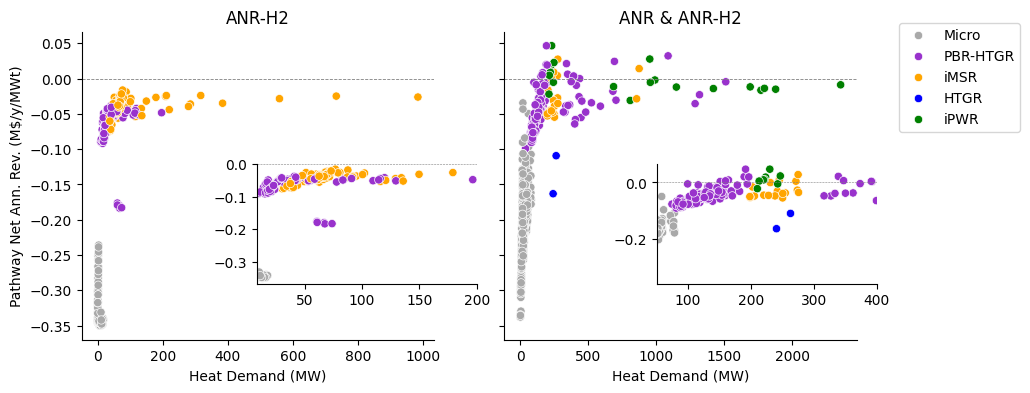

In [36]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,4))
best_pathway['Pathway Net Ann. Rev. (M$/y)'] = best_pathway['Pathway Net Ann. Rev. ($/year)']/1e6
palette={'HTGR':'blue', 'iMSR':'orange', 'iPWR':'green', 'PBR-HTGR':'darkorchid', 'Micro':'darkgrey'}
sns.scatterplot(ax=ax[0], data=best_pathway[best_pathway.Pathway == 'ANR-H2'], x= 'Heat Demand (MW)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=palette)
sns.scatterplot(ax=ax[1], data=best_pathway[best_pathway.Pathway == 'ANR+ANR-H2'], x= 'Heat Demand (MW)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=palette)
ax[0].axhline(0, color='grey', linestyle='--', linewidth=0.6)
ax[0].set_title('ANR-H2')
ax[0].get_legend().set_visible(False)
ax[1].axhline(0, color='grey', linestyle='--', linewidth=0.6)
ax[1].set_title('ANR & ANR-H2')
ax[1].legend(bbox_to_anchor=(1.1, 1.05))
# Zoom of ANR and ANR-H2
# this is an inset axes over the main axes
sub_ax = plt.axes([.7, .25, .22, .3]) 
sns.scatterplot(ax=sub_ax, data=best_pathway[best_pathway.Pathway == 'ANR+ANR-H2'], x= 'Heat Demand (MW)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=palette)
sub_ax.axhline(0, color='grey', linestyle='--', linewidth=0.4)
sub_ax.set_xlim(50,400)
#sub_ax.set_ylim(-.01, 0.2)
sub_ax.get_legend().set_visible(False)
sub_ax.set_xlabel('')
sub_ax.set_ylabel('')
# Zoom of ANR-H2
# this is an inset axes over the main axes
sub_ax = plt.axes([.3, .25, .22, .3]) 
sns.scatterplot(ax=sub_ax, data=best_pathway[best_pathway.Pathway == 'ANR-H2'], x= 'Heat Demand (MW)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=palette)
sub_ax.axhline(0, color='grey', linestyle='--', linewidth=0.4)
sub_ax.set_xlim(8,200)
#sub_ax.set_ylim(-.01, 0.2)
sub_ax.get_legend().set_visible(False)
sub_ax.set_xlabel('')
sub_ax.set_ylabel('')
sns.despine()
fig.savefig('./results/process_heat/best_net_ann_rev_vs_heat_demand.png')

Very small demand are the least profitable to serve, and we observe that for ANR-H2 pathway the most profitable plants require a demand between 50 and 100 MWt while for the ANR & ANR-H2 pathway a profitability maximum is observed between 200 and 300 MWt. 

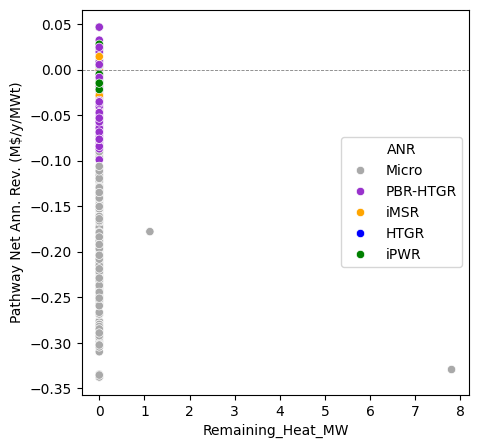

In [37]:
fig, ax = plt.subplots(sharey=True, figsize=(5,5))
palette={'HTGR':'blue', 'iMSR':'orange', 'iPWR':'green', 'PBR-HTGR':'darkorchid', 'Micro':'darkgrey'}
sns.scatterplot(ax=ax, data=best_pathway, x= 'Remaining_Heat_MW', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=palette)
ax.axhline(0, color='grey', linestyle='--', linewidth=0.6)


No clear influence of remaining heat on profitability

### Net Annual Revenues per Industry

In [38]:
map_id_industry =pd.read_excel('./input_data/direct_heat_maxv/maxv_heat_data_old.xlsx')[['FACILITY_ID', 'Industry']]
map_id_industry.drop_duplicates(inplace=True, ignore_index=True)
best_pathway_mapped = best_pathway.merge(map_id_industry, on='FACILITY_ID', how='left')
best_pathway_mapped['Industry'] = best_pathway_mapped['Industry'].fillna('Other')
best_pathway_mapped.replace({'Other_Not Found':'Other'}, inplace=True)

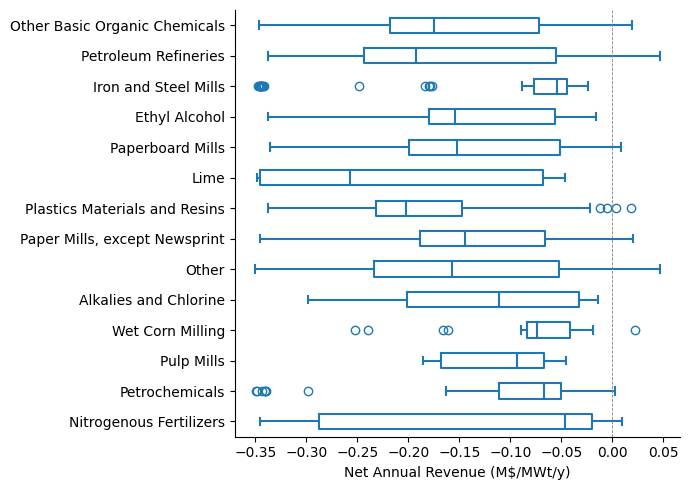

In [39]:
save_path = './results/process_heat/best_net_ann_rev_vs_industry.png'
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(ax=ax, data=best_pathway_mapped, y='Industry', x='Pathway Net Ann. Rev. (M$/y/MWt)',fill=False, width=.5)
ax.set_ylabel('')
ax.set_xlabel('Net Annual Revenue (M$/MWt/y)')
sns.despine()
ax.axvline(0, color='grey', linestyle='--', linewidth=0.6)
#ax.legend(bbox_to_anchor=(-0.1, .01))

fig.tight_layout()
fig.savefig(save_path)

### Cost comparison against NG with CCUS

Cost of NG+CCUS = Avoided NG Cost + Emissions x CCUS Cost

Cost of ANR = CAPEX + O&M + Conversion - H2 PTC 

In [41]:
comp_ccus = best_pathway.copy()
comp_ccus['Cost NG + CCUS (M$/MWt/y)'] = (comp_ccus['Avoided NG Cost ($/y)']+comp_ccus['Emissions_mmtco2/y']*utils.ccus_cost*1e6)/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)
comp_ccus['Cost ANR deployment (M$/MWt/y)'] = (comp_ccus['CAPEX ($/y)']+comp_ccus['O&M ($/y)']+comp_ccus['Conversion']-\
                                                comp_ccus['H2 PTC'])/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)

In [42]:
comp_ccus.columns

Index(['FACILITY_ID', 'STATE', 'Batch_Temp_degC', 'max_temp_degC',
       'Emissions_mmtco2/y', 'Heat Demand (MW)', 'Remaining_Heat_MW',
       'Remaining_temp_degC', 'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK',
       'NG price ($/MMBtu)', 'ANR Net Ann. Rev. ($/year)', 'H2 Dem. (kg/h)',
       'Technology', 'ANR', 'H2 Modules', 'ANR Modules', 'Annual ANR CAPEX',
       'Annual H2 CAPEX', 'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'ANR-H2 VOM',
       'Conversion', 'ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)',
       'H2 PTC', 'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'Net Ann. Rev. ($/year)', 'Pathway', 'Pathway Net Ann. Rev. ($/year)',
       'CAPEX ($/y)', 'O&M ($/y)', 'ANR-H2 Net Ann. Rev. ($/year)',
       'Pathway Net Ann. Rev. (M$/y)', 'Pathway Net Ann. Rev. (M$/y/MWt)',
       'Cost NG + CCUS (M$/MWt/y)', 'Cost ANR deployment (M$/MWt/y)'],
      dtype='object')

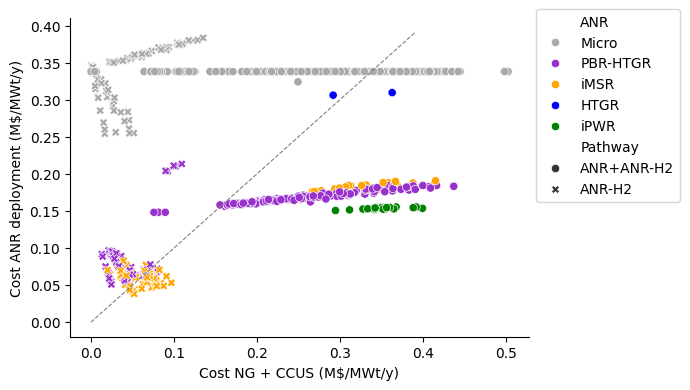

In [43]:
save_path = './results/process_heat/best_comparison_costs_vs_ccus.png'

fig, ax = plt.subplots(figsize=(7,4))
med_x = np.arange(0,0.4, 0.01)
palette={'HTGR':'blue', 'iMSR':'orange', 'iPWR':'green', 'PBR-HTGR':'darkorchid', 'Micro':'darkgrey'}
sns.scatterplot(ax=ax, data=comp_ccus, y='Cost ANR deployment (M$/MWt/y)', x='Cost NG + CCUS (M$/MWt/y)', hue='ANR', style='Pathway',palette=palette)
ax.plot(med_x, med_x, color='grey', linestyle='--', linewidth=0.8)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1.05))

fig.tight_layout()
fig.savefig(save_path)

### Emissions abatement costs

In [44]:
em = best_pathway.copy()
em['Cost ANR ($/y)'] = (em['CAPEX ($/y)']+em['O&M ($/y)']+em['Conversion'])
em['Abatement cost ($/tCO2)'] = em['Cost ANR ($/y)']/(em['Emissions_mmtco2/y']*1e6)
em['Abatement potential (tCO2/y-MWt)'] = 1e6*em['Emissions_mmtco2/y']/em['Depl. ANR Cap. (MWt)']
min_cost = min(em['Abatement cost ($/tCO2)'])
max_cost = max(em['Abatement cost ($/tCO2)'])
min_cost_anr = min(em['Cost ANR ($/y)'])
max_cost_anr = max(em['Cost ANR ($/y)'])
print(min_cost, max_cost)
print(min_cost_anr, max_cost_anr)
print(min(em['Emissions_mmtco2/y']), max(em['Emissions_mmtco2/y']))

108.85021499167534 1667511.493054043
6758424.081348036 1502609636.4185247
4.053e-06 3.399976439


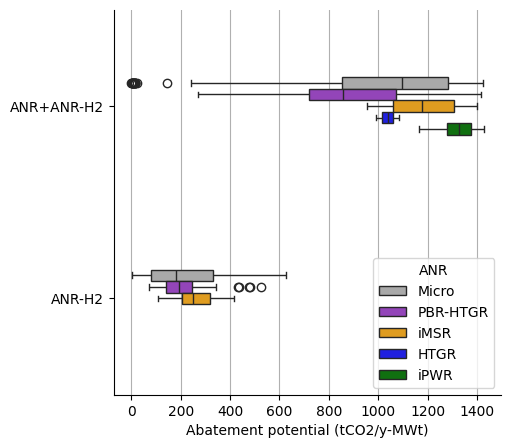

In [50]:
fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(ax=ax, data=em, y='Pathway', x='Abatement potential (tCO2/y-MWt)', palette=palette, hue='ANR',width=0.3)
ax.set_ylabel('')
sns.despine()
ax.xaxis.grid(True)
fig.savefig('./results/process_heat/best_abatement_potential_vs_pathway_anr_design.png')

<Axes: xlabel='max_temp_degC', ylabel='Abatement cost ($/tCO2)'>

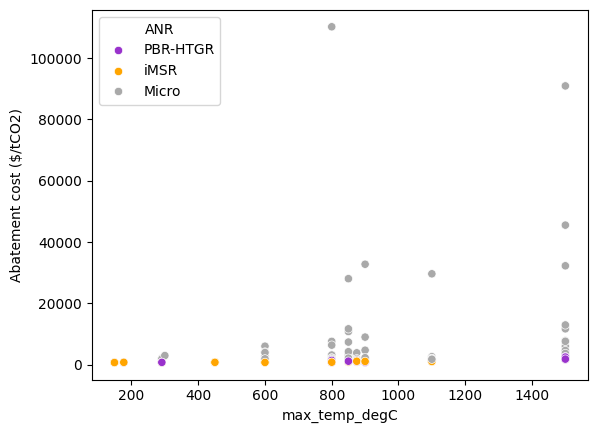

In [51]:
sns.scatterplot(data=em[em.Pathway=='ANR-H2'], y='Abatement cost ($/tCO2)', x='max_temp_degC', palette=palette, hue='ANR')
# nothing with ANR+ANR-h2

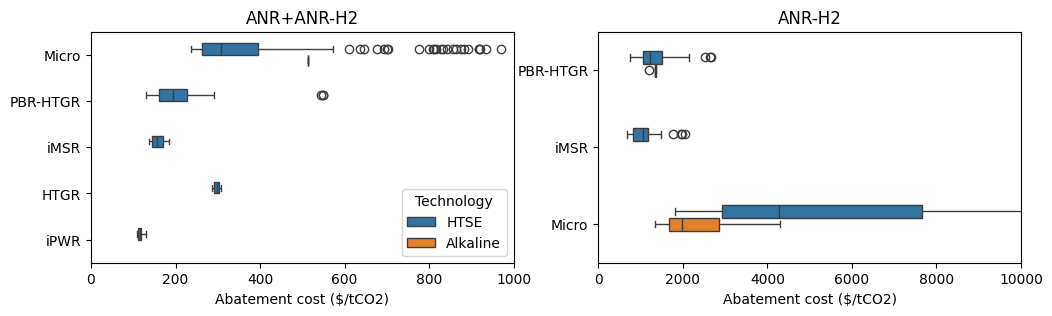

In [73]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
sns.boxplot(ax=ax[0], data=em[em.Pathway=='ANR+ANR-H2'], y='ANR', x='Abatement cost ($/tCO2)', hue='Technology',width=0.5)
sns.boxplot(ax=ax[1], data=em[em.Pathway=='ANR-H2'], y='ANR', x='Abatement cost ($/tCO2)', hue='Technology',width=0.5)
ax[1].set_xlim(0,10000)
ax[1].set_title('ANR-H2')
ax[0].set_xlim(0,1000)
ax[0].set_title('ANR+ANR-H2')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[1].get_legend().set_visible(False)

TODO: For ANR+ANR-H2 separate costs from ANR and ANR-H2 to show the cost of decarbonizing high temperature process heat

### Influence of temperature on profitability

Text(0.5, 1.0, 'ANR & ANR-H2')

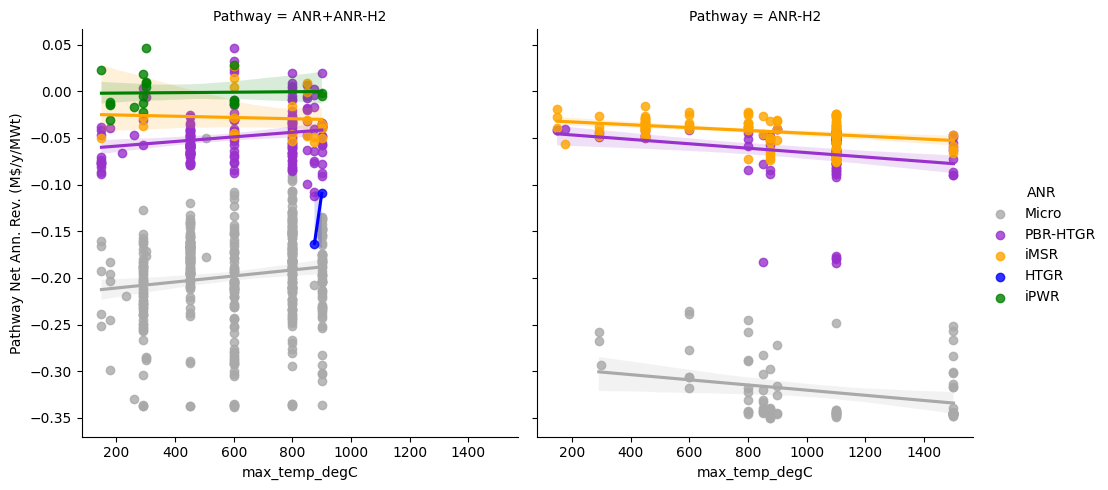

In [251]:
palette={'HTGR':'blue', 'iMSR':'orange', 'iPWR':'green', 'PBR-HTGR':'darkorchid', 'Micro':'darkgrey'}
sns.lmplot( data=best_pathway, x= 'max_temp_degC', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', col='Pathway', palette=palette)
ax.axhline(0, color='grey', linestyle='--', linewidth=0.6)
ax.set_title('ANR & ANR-H2')

No influence of max temperature at facility on profitability

### Influence of electrolysis technology on profitability

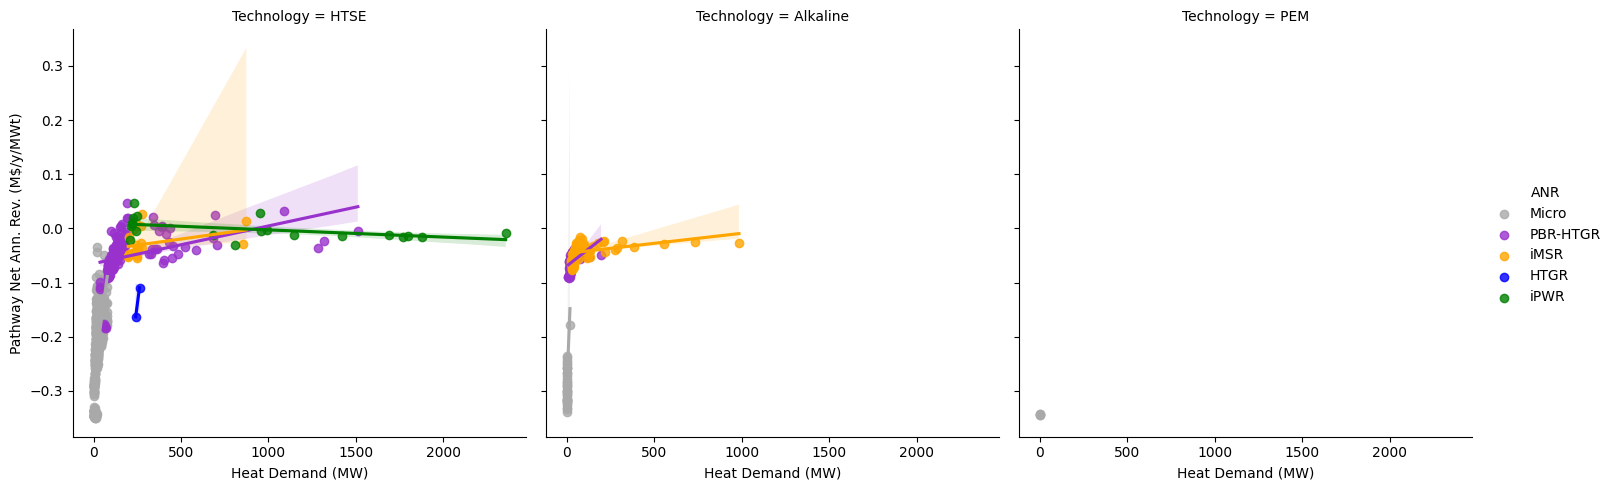

In [261]:


sns.lmplot(data=best_pathway, y= 'Pathway Net Ann. Rev. (M$/y/MWt)', x = 'Heat Demand (MW)', hue='ANR', col='Technology', palette=palette)


### Influence of NG prices

In [122]:
comp_ccus.columns
comp_ccus['Cost NG without CCUS (M$/MWt/y)'] = comp_ccus['Avoided NG Cost ($/y)']/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)

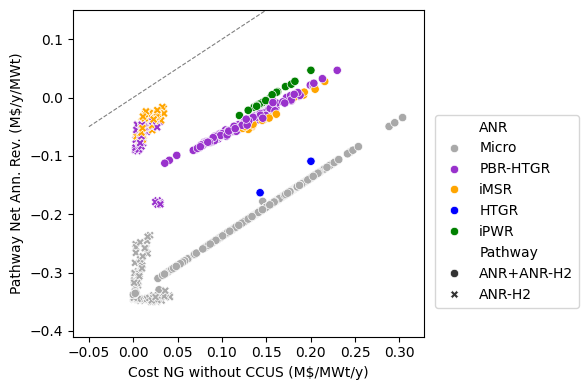

In [141]:
fig, ax = plt.subplots(sharey=True, figsize=(6,4))
palette={'HTGR':'blue', 'iMSR':'orange', 'iPWR':'green', 'PBR-HTGR':'darkorchid', 'Micro':'darkgrey'}
sns.scatterplot(ax=ax, data=comp_ccus, x= 'Cost NG without CCUS (M$/MWt/y)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', style='Pathway', palette=palette)
med_x = np.arange(-0.05,0.32, 0.01)
ax.plot(med_x, med_x, color='grey', linestyle='--', linewidth=0.8)
ax.legend(bbox_to_anchor=(1.01, .7))
ax.set_ylim(-0.41, 0.15)
fig.tight_layout()
fig.savefig('./results/process_heat/best_comparison_costs_vs_ng_wo_ccus.png')


### Breakeven NG prices

In [270]:
# Recalculate NG multiplier from max temperature recorded
bmp = best_pathway_mapped.copy()
bmp['NG Mult (MMBtu/MJ)']  = bmp.apply(lambda x: compute_ng_multiplier(x['max_temp_degC']), axis=1) 
bmp['Breakeven NG price ($/MMBtu)'] = (bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion']-bmp['H2 PTC'])/\
                                              (bmp['NG Mult (MMBtu/MJ)']*bmp['Heat Demand (MW)']*utils.mwh_to_mj*8760)
max_ng = max(bmp['Breakeven NG price ($/MMBtu)'])
min_ng = min(bmp['Breakeven NG price ($/MMBtu)'])
print(f'Breakeven NG prices between {min_ng} and {max_ng} $/MMBtu')

Breakeven NG prices between 6.203658943521423 and 118696.88089111043 $/MMBtu


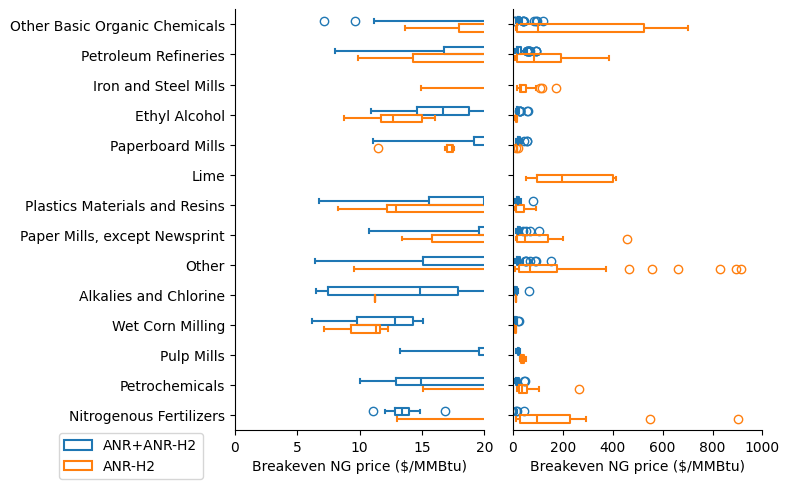

In [296]:
save_path = './results/process_heat/best_be_ng_vs_industry.png'
fig, ax = plt.subplots(1,2,figsize=(8,5), sharey=True)
sns.boxplot(ax=ax[0], data=bmp, y='Industry', x='Breakeven NG price ($/MMBtu)', hue='Pathway',fill=False, width=.5)
sns.boxplot(ax=ax[1], data=bmp, y='Industry', x='Breakeven NG price ($/MMBtu)', hue='Pathway',fill=False, width=.5)
ax[0].set_ylabel('')

ax[0].set_xlim(0,20)
ax[1].set_ylabel('')
ax[1].set_xlim(0,1000)
ax[1].get_legend().set_visible(False)
sns.despine()

ax[0].legend(bbox_to_anchor=(-0.1, .01))

fig.tight_layout()
fig.savefig(save_path)

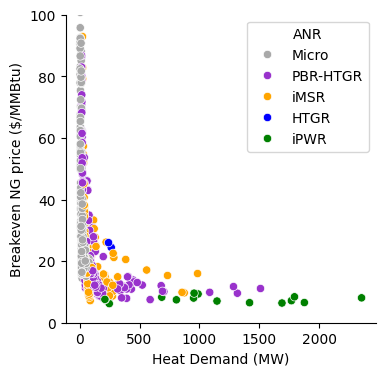

In [295]:
# Scatter plots: Heat demand
fig, ax = plt.subplots(sharey=True, figsize=(4,4))

sns.scatterplot(ax=ax, data=bmp, x= 'Heat Demand (MW)', y = 'Breakeven NG price ($/MMBtu)', hue='ANR', palette=palette)

ax.set_ylim(0,100)
sns.despine()
fig.savefig('./results/process_heat/best_be_ng_vs_heat_demand.png')

### Cashflows breakdown

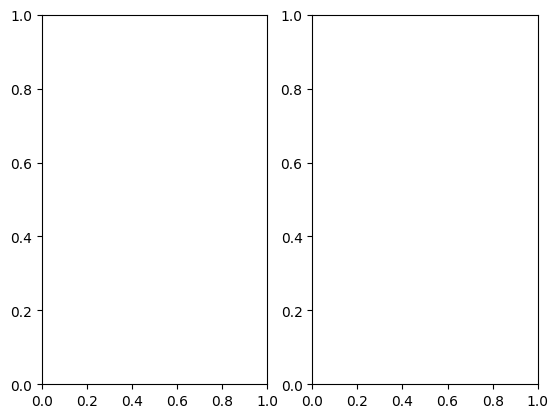

In [390]:
# TODO
fig, ax = plt.subplots(1, 2)

### ANR-H2 v.s. ANR+ANR-H2 net annual revenues

In [391]:
net_rev_comp = ff.merge(fr, on=['FACILITY_ID', 'STATE', 'NG price ($/MMBtu)'])


In [392]:
net_rev_comp = net_rev_comp[['FACILITY_ID', 'STATE', 'NG price ($/MMBtu)', 'ANR-H2 Net Ann. Rev. ($/year)', 'Net Ann. Rev. ($/year)']]


-4.7727435083848
-166.38918402934593
11.661119039126069


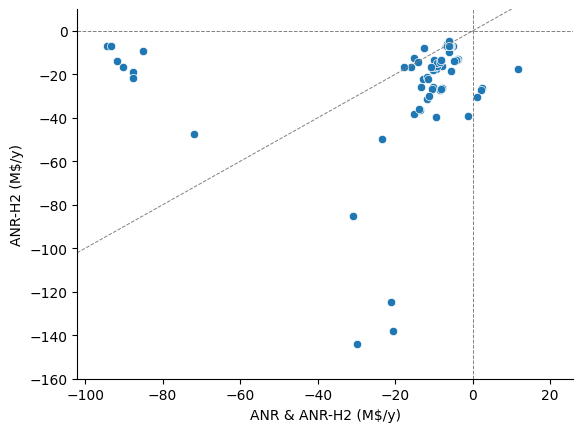

In [393]:

net_rev_comp['ANR-H2 (M$/y)'] = net_rev_comp['ANR-H2 Net Ann. Rev. ($/year)']/1e6
net_rev_comp['ANR & ANR-H2 (M$/y)'] = net_rev_comp['Net Ann. Rev. ($/year)']/1e6
print(max(net_rev_comp['ANR-H2 (M$/y)']))
print(min(net_rev_comp['ANR-H2 (M$/y)']))
print(max(net_rev_comp['ANR & ANR-H2 (M$/y)']))
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=net_rev_comp, x= 'ANR & ANR-H2 (M$/y)', y = 'ANR-H2 (M$/y)')

sns.despine()
ax.set_xlim(-102, 26)
ax.set_ylim(-160,10)
med_x = np.arange(-250,40,0.05)
ax.plot(med_x, med_x, color='grey', linestyle='--', linewidth=0.7)
ax.axvline(0,color='grey', linestyle='--', linewidth=0.7)
ax.axhline(0,color='grey', linestyle='--', linewidth=0.7)

### Facilities with Positive Net Annual Revenues

In [394]:
positive =  best_pathway[best_pathway['Pathway Net Ann. Rev. ($/year)']>0]
em = positive['Emissions_mmtco2/y'].sum()
cap = positive['Depl. ANR Cap. (MWe)'].sum()/1e3
print('Viable avoided emissions: {:05.3f} MMtCO2/y'.format(em))
print('Viable capacity: {:04.3f} GWe'.format(cap))

Viable avoided emissions: 11.939 MMtCO2/y
Viable capacity: 3.541 GWe
